# Neuroprosthetics Exercise 4 - Alexander Koenig

## Subtask 1 - Time Constants and Steady State Values

In [1]:
import numpy as np
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt

rcParams['font.family'] = "Arial"
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['axes.grid'] = True

In [2]:
# define rate equations
alpha_m = lambda V: (2.5 - 0.1*V) / (np.exp(2.5 - 0.1*V) - 1)
alpha_n = lambda V: (0.1 - 0.01*V) / (np.exp(1 - 0.1*V) - 1)
alpha_h = lambda V: 0.07 * np.exp(- V/20)
beta_m = lambda V: 4 * np.exp(- V/18)
beta_n = lambda V: 0.125 * np.exp(- V/80)
beta_h = lambda V: 1 / (np.exp(3 - 0.1*V) + 1)

# temperature correction
k = lambda T: 3 ** (0.1*(T-6.3))

# time constant
tau_x = lambda alpha, beta, k: 1 / ((alpha + beta) * k)

# steady state value
x_inf = lambda alpha, beta: alpha / (alpha + beta)

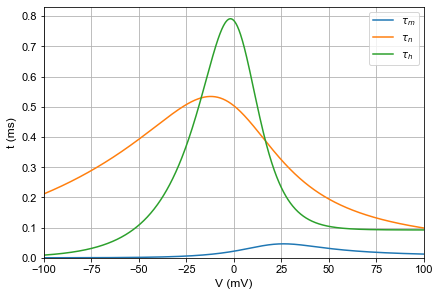

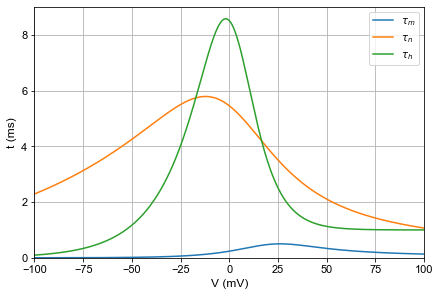

In [3]:
voltages = np.linspace(-100, 100, 1000)
temperatures = [28, 6.3]
alphas = [alpha_m, alpha_n, alpha_h]
betas = [beta_m, beta_n, beta_h]
labels = ["$\u03C4_{m}$", "$\u03C4_{n}$", "$\u03C4_{h}$"]

for temperature in temperatures:
    fig = plt.figure(constrained_layout=True)
    
    for i in range (0,3): 
        values = np.array([tau_x(alphas[i](voltage), betas[i](voltage), k(temperature)) for voltage in voltages])
        plt.plot(voltages, values, label=labels[i])
    
    plt.xlabel("V (mV)")
    plt.ylabel("t (ms)")
    plt.xlim(-100, 100)
    plt.ylim(0)
    plt.legend()
    plt.show()
    fig.savefig(f"../figures/tau_temp{temperature}.pdf")

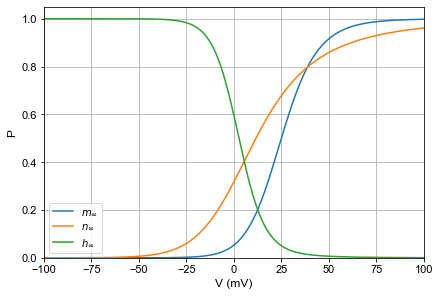

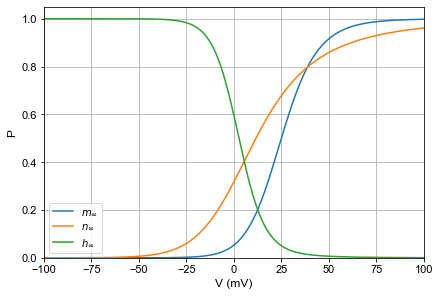

In [4]:
labels = ["$m_{\u221E}$", "$n_{\u221E}$", "$h_{\u221E}$"]

for temperature in temperatures:
    fig = plt.figure(constrained_layout=True)
    
    for i in range (0,3): 
        values = np.array([x_inf(alphas[i](voltage), betas[i](voltage)) for voltage in voltages])
        plt.plot(voltages, values, label=labels[i])
    
    plt.xlabel("V (mV)")
    plt.ylabel("P")
    plt.xlim(-100, 100)
    plt.ylim(0)
    plt.legend()
    plt.show()
    fig.savefig(f"../figures/xinf_temp{temperature}.pdf")

## Subtask 2 - Hodgkin-Huxley Neuron Model

In [5]:
# ionic currents
i_na = lambda m, h, V: 120 * m**3 * h * (V - 115)
i_k = lambda n, V: 36 * n**4 * (V + 12)
i_l = lambda V: 0.3 * (V - 10.6)

# ode for voltage
ode_rhs = lambda i_ion, i_stim: i_stim - i_ion

# gating odes in A, B form for Exponential Euler
A_m = lambda V, T: - 1 / tau_x(alpha_m(V), beta_m(V), k(T))
A_n = lambda V, T: - 1 / tau_x(alpha_n(V), beta_n(V), k(T))
A_h = lambda V, T: - 1 / tau_x(alpha_h(V), beta_h(V), k(T))
B_m = lambda V, T: x_inf(alpha_m(V), beta_m(V)) / tau_x(alpha_m(V), beta_m(V), k(T))
B_n = lambda V, T: x_inf(alpha_n(V), beta_n(V)) / tau_x(alpha_n(V), beta_n(V), k(T))
B_h = lambda V, T: x_inf(alpha_h(V), beta_h(V)) / tau_x(alpha_h(V), beta_h(V), k(T))

def exponential_euler_step(A, B, prev_value, step_size):
    """One time step of Exponential Euler Method"""
    
    next_value = prev_value*np.exp(A*step_size) + B/A*(np.exp(A*step_size) - 1)
    
    return next_value

def explicit_euler_step(ode_rhs, prev_value, step_size):
    """One time step of Explicit Euler Method"""
    
    next_value = prev_value + ode_rhs * step_size
    
    return next_value

def hh_current(V, T, prev_gating_vars, step_size):
    """Solves gating odes for one time step and returns ion currents and gating variables in next time step"""

    m = exponential_euler_step(A_m(V, T), B_m(V, T), prev_gating_vars[0], step_size)
    n = exponential_euler_step(A_n(V, T), B_n(V, T), prev_gating_vars[1], step_size)
    h = exponential_euler_step(A_h(V, T), B_h(V, T), prev_gating_vars[2], step_size)
    
    i_ions = np.array([i_na(m, h, V), i_k(n, V), i_l(V)])
    gating_vars = np.array([m, n, h])
    
    return i_ions, gating_vars

def get_i_stim(T, t): 
    """Definition of stimulation current as given in exercise"""
    if T == 6.3:
        if t > 0 and t < 5:
            return 1
        elif t > 15 and t < 20:
            return 2
        elif t > 30 and t < 35:
            return 3
        elif t > 45 and t < 50:
            return 4
        elif t > 60 and t < 65:
            return 5
        else:
            return 0
    elif T == 28:
        if t > 0 and t < 5:
            return 2
        elif t > 15 and t < 20:
            return 4
        elif t > 30 and t < 35:
            return 8
        elif t > 45 and t < 50:
            return 16
        elif t > 60 and t < 65:
            return 32
        else:
            return 0

def hh_model(T, start_time, end_time, step_size):
    
    V_rest = 0
    V_membrane = np.array([V_rest])
    times = np.arange(start_time, end_time, step_size)
    
    # gating variables at resting potential
    m_inf = x_inf(alpha_m(V_rest), beta_m(V_rest))
    n_inf = x_inf(alpha_n(V_rest), beta_n(V_rest))
    h_inf = x_inf(alpha_h(V_rest), beta_h(V_rest))
    gating_vars = np.array([[m_inf, n_inf, h_inf]])
    
    # currents at resting potential
    i_ions = np.array([i_na(m_inf, h_inf, V_rest), i_k(n_inf, V_rest), i_l(V_rest)])
    
    for time in times[1:]:
        
        # exponential euler step
        next_i_ions, next_gating_vars = hh_current(V_membrane[-1], T, gating_vars[-1], step_size) 
        i_ions = np.vstack((i_ions, next_i_ions))
        gating_vars = np.vstack((gating_vars, next_gating_vars))
        
        # explicit euler step
        next_V_membrane = explicit_euler_step(ode_rhs(np.sum(next_i_ions), get_i_stim(T, time)), V_membrane[-1], step_size)
        V_membrane = np.append(V_membrane, next_V_membrane)
    
    return V_membrane, gating_vars, i_ions, times

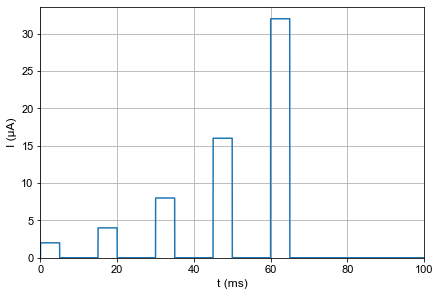

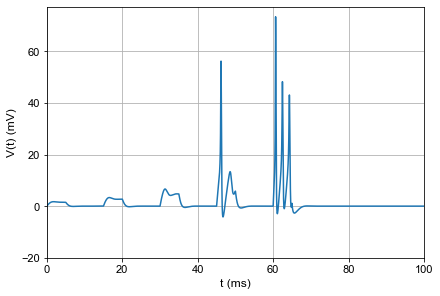

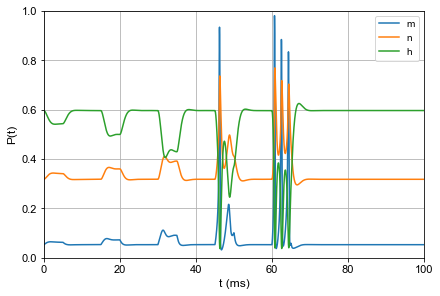

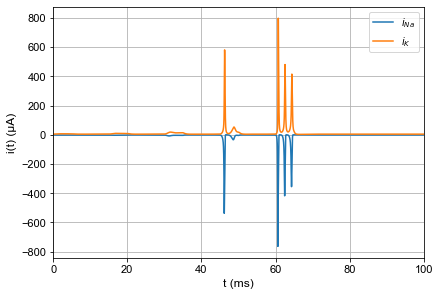

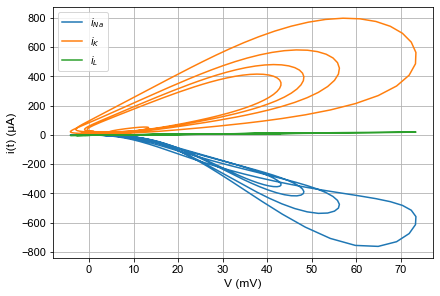

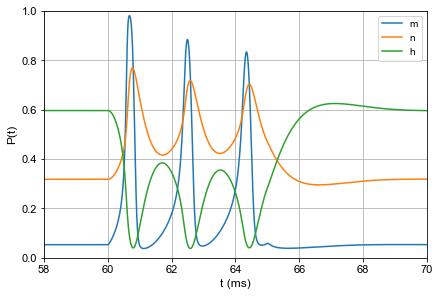

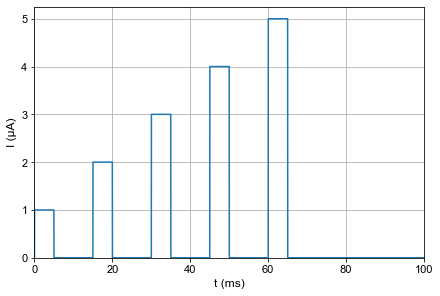

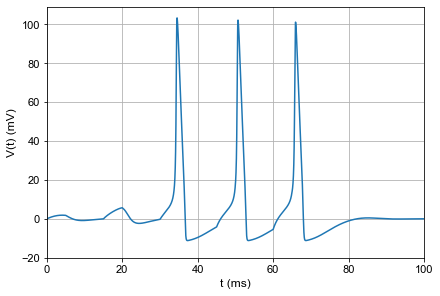

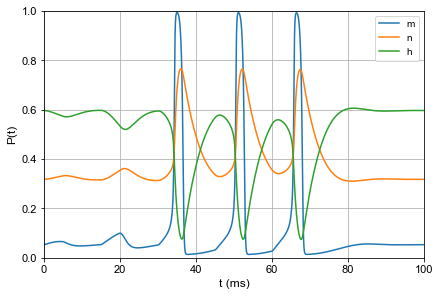

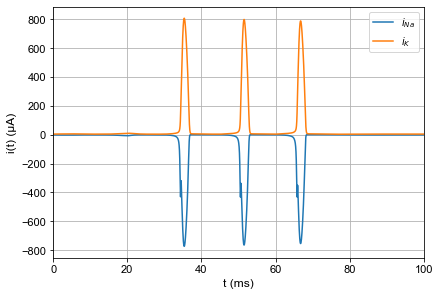

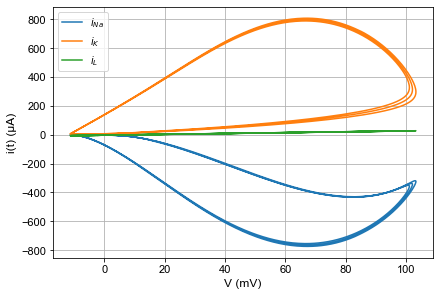

In [6]:
for temperature in temperatures:
    
    # plot input currents
    fig = plt.figure(constrained_layout=True)
    times = np.arange(0, 100, 0.01)
    values = np.array([get_i_stim(temperature, time) for time in times])
    plt.plot(times, values)
    plt.xlabel("t (ms)")
    plt.ylabel("I (\u00B5A)")
    plt.xlim(0, 100)
    plt.ylim(0)
    plt.show()
    fig.savefig(f"../figures/inputcur_temp{temperature}.pdf")
    
    V_membrane, gating_vars, i_ion, times = hh_model(temperature, 0, 100, 0.01)
    
    # plot membrane potential
    fig = plt.figure(constrained_layout=True)
    plt.plot(times, V_membrane)
    plt.xlabel("t (ms)")
    plt.ylabel("V(t) (mV)")
    plt.xlim(0, 100)
    plt.ylim(-20)
    plt.show()
    fig.savefig(f"../figures/potential_temp{temperature}.pdf")
    
    # plot gating variables
    fig = plt.figure(constrained_layout=True)
    labels = ['m', 'n', 'h']
    for i in range(0,3):
        plt.plot(times, gating_vars[:,i], label=labels[i])
    plt.xlabel("t (ms)")
    plt.ylabel("P(t)")
    plt.xlim(0, 100)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    fig.savefig(f"../figures/gatingvars_temp{temperature}.pdf")
    
    # plot Na and K currents
    fig = plt.figure(constrained_layout=True)
    labels = ['$i_{Na}$', '$i_{K}$']
    for i in range(0,2):
        plt.plot(times, i_ion[:,i], label=labels[i])
    plt.xlabel("t (ms)")
    plt.ylabel("i(t) (\u00B5A)")
    plt.xlim(0, 100)
    plt.legend()
    plt.show()
    fig.savefig(f"../figures/currents_temp{temperature}.pdf")
    
    # phase plot
    fig = plt.figure(constrained_layout=True)
    labels = ['$i_{Na}$', '$i_{K}$', '$i_{L}$']
    for i in range(0,3):
        plt.plot(V_membrane, i_ion[:,i], label=labels[i])
    plt.xlabel("V (mV)")
    plt.ylabel("i(t) (\u00B5A)")
    plt.legend()
    plt.show()
    fig.savefig(f"../figures/phase_temp{temperature}.pdf")

    # close up plot
    if temperature == 28:
        fig = plt.figure(constrained_layout=True)
        labels = ['m', 'n', 'h']
        for i in range(0,3):
            plt.plot(times, gating_vars[:,i], label=labels[i])
        plt.xlabel("t (ms)")
        plt.ylabel("P(t)")
        plt.xlim(58, 70)
        plt.ylim(0,1)
        plt.legend()
        plt.show()
        fig.savefig(f"../figures/closeup_temp{temperature}.pdf")